In [3]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout, Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.python.client import device_lib
# from tensorflow.data.Dataset import from_tensor_slices
from tensorflow import cast, float32, expand_dims, TensorSpec
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# Data behandling

Den første del går ud på at klargøre vores data til brug.  
Her starter vi med at skrive path op til vores trænings, test og valideringsdata.

In [4]:
train_path="data/train"
test_path="data/test"
val_path="data/valid"

Dem vil vi så bruge til at hente alle billederne.  
De bliver gemt i en liste og bliver fundet ved at gå igennem alle subfolders:
```py
for folder in os.listdir(train_path):
  sub_path=train_path+"/"+folder
  for img in os.listdir(sub_path):
```
Her kan man se at vi iterator over alle directories i trainingsmappen.  
Der tager vi så alle de billeder og loader dem med cv2 samt ændre størrelsen på billederne så de kræver mindre at bruge.
```py
image_path=sub_path+"/"+img
img_arr=cv2.imread(image_path)
img_arr=cv2.resize(img_arr,(224,224))
train_x.append(img_arr)
```

In [5]:
print("Retrieving training Data")

train_x=[]
for folder in os.listdir(train_path):
  sub_path=train_path+"/"+folder
  for img in os.listdir(sub_path):
    image_path=sub_path+"/"+img
    img_arr=cv2.imread(image_path)
    img_arr=cv2.resize(img_arr,(224,224))
    train_x.append(img_arr)

print("Retrieving test Data")

test_x=[]
for folder in os.listdir(test_path):
  sub_path=test_path+"/"+folder
  for img in os.listdir(sub_path):
    image_path=sub_path+"/"+img
    img_arr=cv2.imread(image_path)
    img_arr=cv2.resize(img_arr,(224,224))
    test_x.append(img_arr)
    
print("Retrieving validation Data")
    
val_x=[]
for folder in os.listdir(val_path):
  sub_path=val_path+"/"+folder
  for img in os.listdir(sub_path):
    image_path = sub_path+"/"+img
    img_arr=cv2.imread(image_path)
    img_arr=cv2.resize(img_arr,(224,224))
    val_x.append(img_arr)

Retrieving training Data
Retrieving test Data
Retrieving validation Data


Efter det konverterer vi dataen til et numpy array, så vi kan arbejde med det.  
Det bruger vi så til at broadcaste en division på alle elementer i arrayet, så vi får en værdi mellem 0 og 1.

In [6]:
train_x=np.array(train_x)
test_x=np.array(test_x)
val_x=np.array(val_x)
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

Den næste del af koden finder labels til vores billeder så vi senere kan bruge dem til at træne.  
Det gør vi ved hjælp af ```ImageDataGenerator``` man kan bruge i sammenarbejde med ```flow_from_directory()```.

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_path,
 target_size = (224, 224),
 batch_size = 32,
 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
 target_size = (224, 224),
 batch_size = 32,
 class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
 target_size = (224, 224),
 batch_size = 32,
 class_mode = 'sparse')

Found 9700 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


Dem kan vi så gemme seperat så vi har labels og billeder i henholdsvigst y og x arrays.  
Det gøres ved at tage ```.classes```:

In [8]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

Her kan man se at der er en del mere træningsdata da det er det vi har brug for mest af:

In [9]:
train_y.shape,test_y.shape,val_y.shape

((9700,), (100,), (200,))

# Modelgeneration
Nu har vi forberedt dataen og kan begynde at genererer modelen.  
Her har vi brugt størrelsen på billederne med en ekstra dimension på 3 for hver farvekanal.  
Her starter vi med at bruge VGG19 hvor vi definerer størrelsen på inputtet samt hvilken type vægte vi gerne ville bruge.  

Vi sætter også alle de lag der følger med VGG19 til ikke at skulle trænes da de allerede er fortrænet.

In [10]:
vgg = VGG19(input_shape=[224,224] + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False

Herefter kan vi tilføje til modelen så den passer til vores brug.  

Her starter vi med at flatten vgg output. Der kan vi så efter bruge et dense lag hvor vi har specificeret 5 output node hvilket passer da vi har fem typer af frugt.  
Her bruger vi også softmax som aktivations classifier da vi arbejder med multi-class klassifikation.

In [11]:
x = Flatten()(vgg.output)

prediction = Dense(5, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

#For at få et overblik over modellen kan vi:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │       125,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,149,829 (76.87 MB)

 Trainable params: 125,445 (490.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Så kan man compile modellen hvor vi har brugt accuracy som vores metric at måle hvor godt den klarer sig på.

Her sætter vi også early_stop op der siger at hvis den ser at vi mister kvalitet for mange gange i træk stopper den før den er helt færdig.  
Det er praktisk da man tit kan risikerer ikke at få noget ud af det sidste og at det derfor bare er spild af tid.

In [12]:
model.compile(
loss='sparse_categorical_crossentropy',
optimizer="adam",
metrics=['accuracy']
)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Til sidst kan vi kører modellen hvor vi har specificeret vores early_stop samt trænings- og valideringsdata.  

Det gør vi da den bruger valideringsdataen til at vurderer den selv efter hver epoke.

In [29]:
result = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - accuracy: 0.9653 - loss: 0.1051 - val_accuracy: 0.8000 - val_loss: 0.6589
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 655s 2s/step - accuracy: 0.9841 - loss: 0.0588 - val_accuracy: 0.8100 - val_loss: 0.7352
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.9946 - loss: 0.0316 - val_accuracy: 0.8050 - val_loss: 0.6680
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 644s 2s/step - accuracy: 0.9980 - loss: 0.0236 - val_accuracy: 0.8150 - val_loss: 0.6722
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.9994 - loss: 0.0164 - val_accuracy: 0.8250 - val_loss: 0.6961
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.9997 - loss: 0.0103 - val_accuracy: 0.8100 - val_loss: 0.6569
Epoch 7/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - accuracy: 0.9981 - loss: 0.0179 - val_accuracy: 0.8050 - val_loss: 0.7768
Epoch 8/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 1664s 5s/step - accuracy: 0.9969 - loss: 0.0255 - val_acc

# Efterbehandling

Det kan vi så plotte for at se hvordan den klarer præcision og loss.  

Her kan man se at den generelt bliver bedre dog er det minimalt hvor meget man får efter de første epoker.  
Man kan også se at den ikke er specielt præcis hvilket skyldes manglen på processorkraft så man kan kører i større opløsning samt manuelt datavalg.

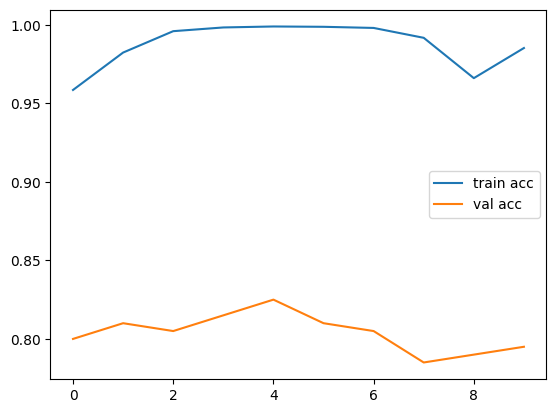

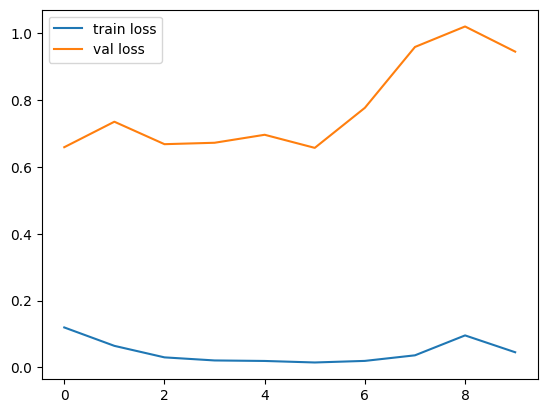

In [30]:
# accuracies
plt.plot(result.history['accuracy'], label='train acc')
plt.plot(result.history['val_accuracy'], label='val acc')
plt.legend()
# plt.savefig('vgg-acc-rps-1.png')
plt.show()
# loss
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.legend()
# plt.savefig('vgg-loss-rps-1.png')
plt.show()

Vi kan til sidst gemme modelen så man kan bruge den senere og så kan man loade den igen.

In [31]:
model.save("model.keras")


In [14]:
from tensorflow.keras.models import load_model

model = load_model("model.keras")

Vi kan også se data over præcision for hver enkel frugt.  
Her kan man se at den generelt er præcis og man ser ikke den store svingning undtagen for bananer dog skyldes det nok at vores test data kun er på 100 billeder.

In [23]:
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

print(classification_report(y_pred,test_y))
print(confusion_matrix(y_pred,test_y))

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       1.00      0.74      0.85        27
           2       0.85      0.81      0.83        21
           3       0.80      0.80      0.80        20
           4       0.80      0.94      0.86        17

    accuracy                           0.83       100
   macro avg       0.83      0.84      0.83       100
weighted avg       0.85      0.83      0.83       100

[[14  0  0  1  0]
 [ 2 20  2  2  1]
 [ 1  0 17  1  2]
 [ 3  0  0 16  1]
 [ 0  0  1  0 16]]


Her kan vi også teste med billeder der er helt nye fundet fra google.  
Mønsteret fortsætter her hvor de fleste virker men at den har meget svært ved at finde ud af hvad vindruer er.  
Det skyldes at i den lave opløsning kan de nemt ligner et æble eller en mango.

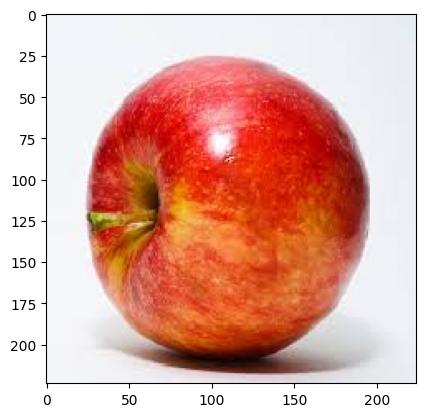

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
[[8.6373633e-01 0.0000000e+00 1.3626365e-01 6.7784639e-22 0.0000000e+00]]
Apple


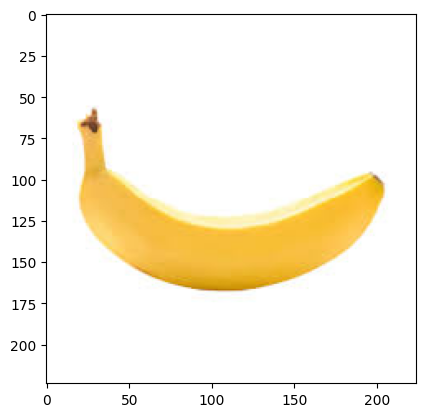

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[[0. 1. 0. 0. 0.]]
Banan


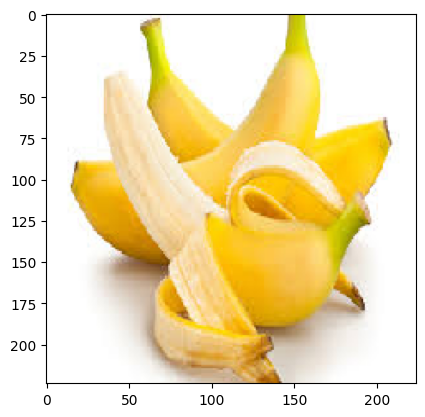

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
[[0. 1. 0. 0. 0.]]
Banan


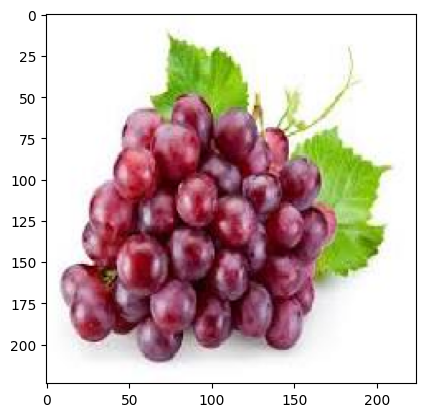

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
[[0. 0. 1. 0. 0.]]
Grape


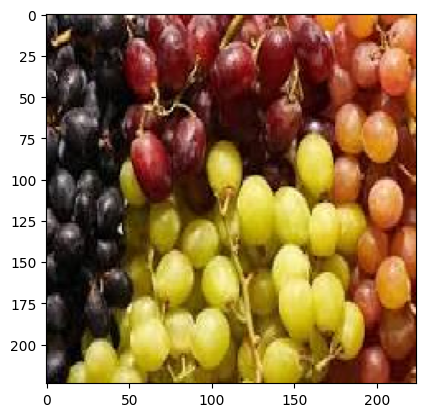

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[[1.599382e-20 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00]]
Mango


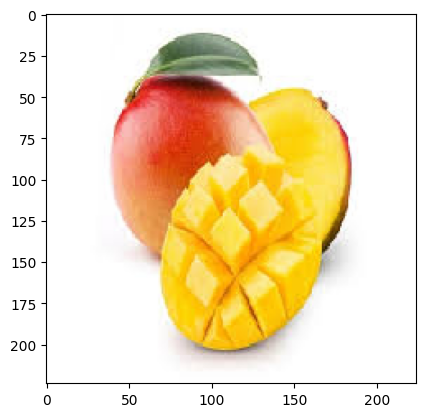

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
[[0. 0. 0. 1. 0.]]
Mango


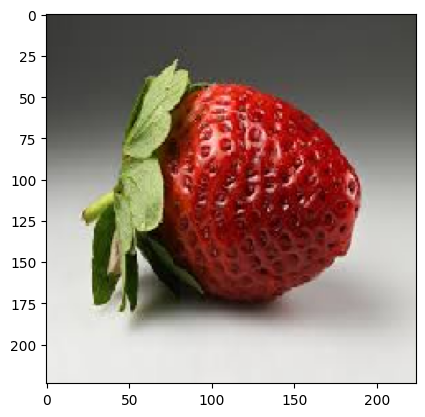

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
[[0. 0. 0. 0. 1.]]
Strawberry


In [22]:
path="test"
for img in os.listdir(path):
    img=image.load_img(path+"/"+img,target_size=(224,224))
    plt.imshow(img)
    plt.show()
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
    pred=model.predict(images,batch_size=1) 
    print(pred)
    if pred[0][0]>0.5:
        print("Apple")
    elif pred[0][1]>0.5:
        print("Banan")
    elif pred[0][2]>0.5:
        print("Grape")
    elif pred[0][3]>0.5:
        print('Mango')
    elif pred[0][4]>0.5:
        print('Strawberry')
    else:
        print("Unknown")

# Data augmentation

In [2]:
image, label = next(iter(training_set))
print(np.max(image[0]))
plt.imshow(image[0])

NameError: name 'training_set' is not defined

(224, 224, 3)
Min and max pixel values: 0.0 1.0


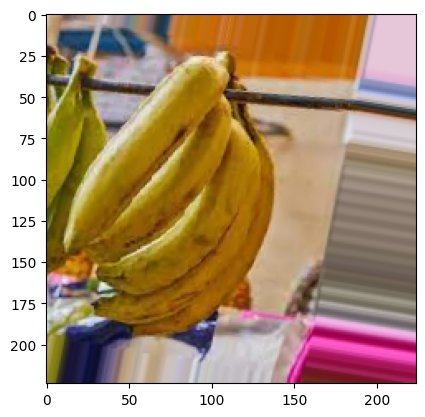

In [32]:
resize_and_rescale = Sequential([
  Resizing(224, 224),
])

result = resize_and_rescale(image[0])
print(result.shape)

plt.imshow(result)

print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

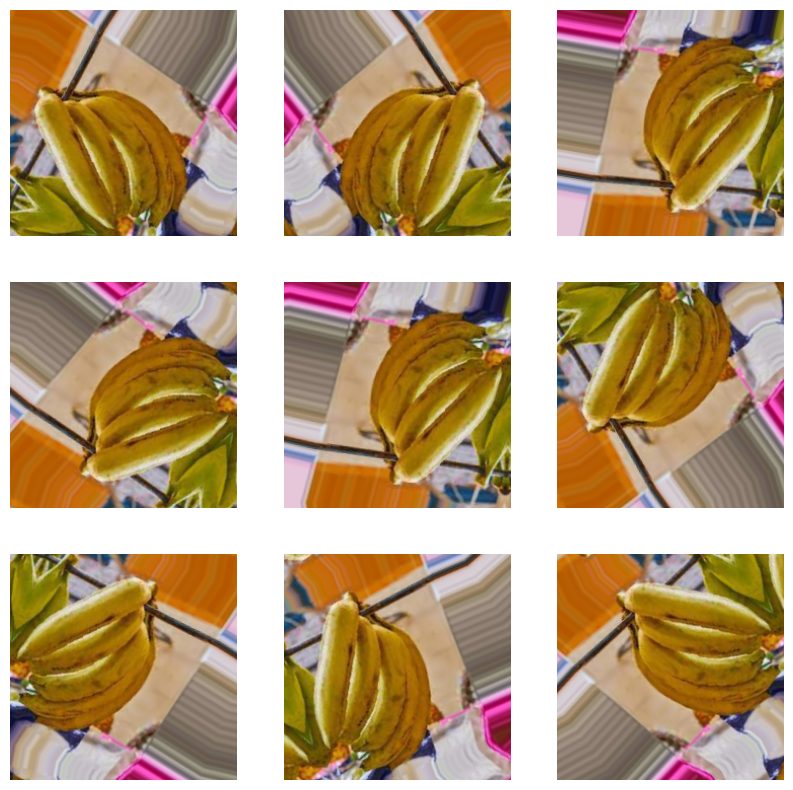

In [33]:
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

image = cast(expand_dims(result, 0), float32)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")


In [15]:
batch_size = 32
AUTOTUNE = AUTOTUNE

def prepare(ds, dy, shuffle=False, augment=False):
  ds
  # print(next(iter(ds)))
  # Resize and rescale all datasets.
  # ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
  ds = ds.map(lambda x: resize_and_rescale(x))

  if shuffle:
    ds = ds.shuffle(1000)
  # print(next(iter(ds)))

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  print(dy)
  if augment:
    # ds.map(lambda x: print(x.shape, dy.shape))
    for i in zip(ds, [i for i in dy]):
      print(i[0].shape, i[1])
    # ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                # num_parallel_calls=AUTOTUNE)

    # ds = data_augmentation(next(iter(ds)), training=True)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [23]:
train_x = Dataset.from_tensor_slices(train_x)
val_x = Dataset.from_tensor_slices(val_x)
test_x = Dataset.from_tensor_slices(test_x)
backup = train_x

ValueError: Slicing dataset elements is not supported for rank 0.

In [40]:
out = prepare(train_x, train_y, shuffle=True, augment=True)
out_val = prepare(val_x)
out_test = prepare(test_x)

[0 0 0 ... 4 4 4]
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(32, 224, 224, 3) 0
(3

TypeError: prepare() missing 1 required positional argument: 'dy'